In [1]:
from dichasus_cf0x import training_set, spec
import matplotlib.animation as manimation
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import hexbinutils
import matplotlib
import scipy
import tqdm

2023-10-23 14:35:59.094195: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 14:35:59.876080: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-23 14:36:00.736142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-23 14:36:00.760670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
# We assume that the z coordinate of the transmit antenna is fixed and known
groundtruth_positions = []
for csi, pos, time in training_set:
    groundtruth_positions.append(pos.numpy())

groundtruth_positions = np.asarray(groundtruth_positions)

HEIGHT = np.mean(groundtruth_positions[:,2])

# Count number of datapoints in training set (for progress bar)
TOTAL_DATAPOINTS = len(groundtruth_positions)

In [3]:
estimated_aoas = np.load("results/estimated_aoas.npy")
estimated_toas = np.load("results/estimated_toas.npy")
delayspreads = np.load("results/delayspreads.npy")

In [4]:
assert(len(estimated_aoas) == TOTAL_DATAPOINTS)
assert(len(estimated_toas) == TOTAL_DATAPOINTS)
assert(len(delayspreads) == TOTAL_DATAPOINTS)

In [5]:
SPEED_OF_LIGHT = 299792458
BANDWIDTH = 50e6
MEAN_TOA = np.mean(estimated_toas)

In [6]:
# These are some empirically determined heuristics, may be further tweaked
def get_aoa_vonmises_kappas(delayspreads):
    return 0.0000003 / (delayspreads + 0.025e-7)

def get_toa_variances(delayspreads):
    return 1 + (delayspreads * 1e7) ** 4

In [7]:
# Can generate either a TDoA-based or a ToA-based likelihood function.
# * If likelihood function is TDoA-based, then function parameters are location estimates (x, y, z)
# * If likelihood function is ToA-based, then function parameters are location + time offset estimates (x, y, z, t_off)
def get_likelihood_function(aoa_datapoint, toa_datapoint, rms_delay_spreads, differential_time = False, use_toa = True, use_aoa = True, only_arrays = None):
    if only_arrays is None:
        only_arrays = list(range(len(array_positions)))

    def likelihood_func(parameters):
        array_positions_to_consider = array_positions[only_arrays]
        array_normalvectors_to_consider = array_normalvectors[only_arrays]

        # "relative_pos" has shape (number of positions, number of arrays, 3 spatial dimensions)
        relative_pos = parameters[:,np.newaxis,:3] - array_positions_to_consider

        if use_aoa:
            # Compute ideal 2D AoAs at given positions, shape: (number of positions, number of arrays)
            ideal_aoas = np.arctan2(-relative_pos[:, :, 1], -relative_pos[:, :, 0]) - np.arctan2(-array_normalvectors_to_consider[:, 1], -array_normalvectors_to_consider[:, 0])
    
            # Compute AoA likelihoods based on von Mises distribution
            kappa = get_aoa_vonmises_kappas(rms_delay_spreads)
            aoa_datapoint_to_consider = aoa_datapoint[only_arrays]
            aoa_likelihoods = np.exp(kappa * np.cos(ideal_aoas - aoa_datapoint_to_consider)) / (2 * np.pi * np.i0(kappa))

        if use_toa:
            # Compute ideal TDoAs at given positions, shape: (number of positions, number of arrays)
            ideal_toas = np.sqrt(np.sum(np.square(relative_pos), axis = -1)) / SPEED_OF_LIGHT * BANDWIDTH
            toa_datapoint_to_consider = toa_datapoint[only_arrays]

            if differential_time:
                # Compute TDoA likelihoods based on Gaussian distribution. tdoa_difference has shape (number of positions, number of array-pairs)
                arraysA, arraysB = np.triu_indices(len(toa_datapoint_to_consider), k = 1)
                estimated_tdoas = toa_datapoint_to_consider[arraysB] - toa_datapoint_to_consider[arraysA]
                ideal_tdoas = ideal_toas[:,arraysB] - ideal_toas[:,arraysA]
                tdoa_difference = ideal_tdoas - estimated_tdoas
                variances = get_toa_variances(np.maximum(rms_delay_spreads[arraysA], rms_delay_spreads[arraysB]))
                toa_likelihoods = np.einsum("a,pa->pa", np.divide(1, np.sqrt(2 * np.pi * variances)), np.exp(-0.5 * np.divide(np.square(tdoa_difference), variances)))
            else:
                # Compute ToA likelihoods based on Gaussian distribution. toa_differences has shape (number of positions, number of arrays)
                toa_differences = ideal_toas - toa_datapoint_to_consider + parameters[:,3][:,np.newaxis]
                variances = get_toa_variances(rms_delay_spreads[only_arrays])
                toa_likelihoods = np.einsum("a,pa->pa", np.divide(1, np.sqrt(2 * np.pi * variances)), np.exp(-0.5 * np.divide(np.square(toa_differences), variances)))

        likelihoods = np.ones_like(len(parameters))
        if use_toa:
            likelihoods = np.multiply(likelihoods, np.product(toa_likelihoods, axis = -1))

        if use_aoa:
            likelihoods = np.multiply(likelihoods, np.product(aoa_likelihoods, axis = -1))

        return likelihoods

    return likelihood_func

In [8]:
# Retrieve antenna array positions and normal vectors
array_positions = np.zeros((len(spec["antennas"]), 3))
array_normalvectors = np.zeros((len(spec["antennas"]), 3))

for antidx, antenna in enumerate(spec["antennas"]):
    array_positions[antidx] = np.asarray(antenna["location"])
    array_normalvectors[antidx] = np.asarray(antenna["direction"])

In [9]:
# Generate grid of potential TX positions, used for initializing optimization algorithm
candidate_xrange = np.linspace(np.min(array_positions[:,0]) - 5, np.max(array_positions[:,0]) + 5, 100)
candidate_yrange = np.linspace(np.min(array_positions[:,1]) - 5, np.max(array_positions[:,1]) + 5, 100)
candidate_initial_positions = np.transpose(np.meshgrid(candidate_xrange, candidate_yrange, HEIGHT)).reshape(-1, 3)

In [10]:
def estimate_position_aoa_toa(index, use_toa = True, use_aoa = True, only_arrays = None):
    aoa_datapoint = estimated_aoas[index]
    toa_datapoint = estimated_toas[index]
    ds_datapoint = delayspreads[index]

    # We use the TDoA-based likelihood function to get a rough initial estimate, then the ToA-based likelihood function for optimization
    tdoa_likelihood_func = get_likelihood_function(aoa_datapoint, toa_datapoint, ds_datapoint, differential_time = True, use_toa = use_toa, use_aoa = use_aoa, only_arrays = only_arrays)
    toa_likelihood_func = get_likelihood_function(aoa_datapoint, toa_datapoint, ds_datapoint, differential_time = False, use_toa = use_toa, use_aoa = use_aoa, only_arrays = only_arrays)

    # Find most likely initialization position based on AoA + TDoA
    initial_point = candidate_initial_positions[np.argmax(tdoa_likelihood_func(candidate_initial_positions))]

    # Use scipy.optimize to find most likely TX position
    init_value = np.asarray([initial_point[0], initial_point[1], MEAN_TOA])
    optimize_res = scipy.optimize.minimize(lambda pos_and_time : -toa_likelihood_func(np.asarray([[pos_and_time[0], pos_and_time[1], HEIGHT, pos_and_time[2]]])), init_value, options = {"gtol": 1e-8})

    return np.asarray([optimize_res.x[0], optimize_res.x[1]])

In [11]:
VIDEO_FRAMES = 5000
USE_TOA = True
USE_AOA = True
ONLY_ARRAYS = None
arrays_fname = ("_arrays_" + "_".join([str(a) for a in ONLY_ARRAYS]) + "_") if ONLY_ARRAYS is not None else ""
outfile = "results/out" + ("_toa" if USE_TOA else "") + ("_aoa" if USE_AOA else "") + arrays_fname + ".mp4"
FPS = 60
DPI = 120
if ONLY_ARRAYS is None:
    ONLY_ARRAYS = list(range(len(array_positions)))

In [12]:
assert(VIDEO_FRAMES < len(groundtruth_positions))

 32%|███▏      | 1621/5000 [03:27<06:42,  8.39it/s]/tmp/ipykernel_109876/1079480808.py:129: RuntimeWarning: invalid value encountered in divide
  likelihoods = likelihoods / np.max(likelihoods)
 46%|████▋     | 2314/5000 [04:50<06:21,  7.04it/s]/tmp/ipykernel_109876/1079480808.py:129: RuntimeWarning: invalid value encountered in divide
  likelihoods = likelihoods / np.max(likelihoods)
 59%|█████▉    | 2947/5000 [06:06<04:12,  8.14it/s]/tmp/ipykernel_109876/1079480808.py:129: RuntimeWarning: invalid value encountered in divide
  likelihoods = likelihoods / np.max(likelihoods)
 69%|██████▊   | 3433/5000 [07:05<03:22,  7.74it/s]/tmp/ipykernel_109876/1079480808.py:129: RuntimeWarning: invalid value encountered in divide
  likelihoods = likelihoods / np.max(likelihoods)
 86%|████████▋ | 4316/5000 [08:54<01:31,  7.47it/s]/tmp/ipykernel_109876/1079480808.py:129: RuntimeWarning: invalid value encountered in divide
  likelihoods = likelihoods / np.max(likelihoods)
 96%|█████████▌| 4788/5000 [09

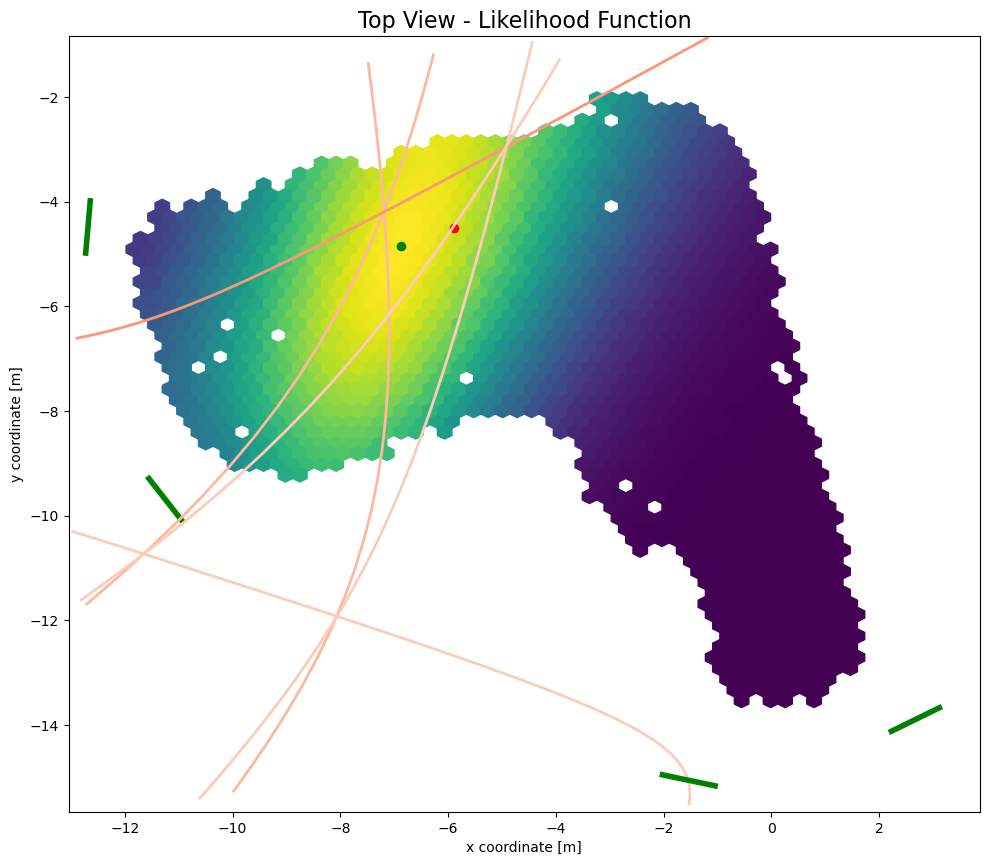

In [13]:
# Determine area size
pos_xlim = [np.min(groundtruth_positions[:, 0]), np.max(groundtruth_positions[:, 0])]
pos_ylim = [np.min(groundtruth_positions[:, 1]), np.max(groundtruth_positions[:, 1])]

for pos in array_positions:
    pos_xlim[0] = min(pos_xlim[0], pos[0]) - 0.3
    pos_xlim[1] = max(pos_xlim[1], pos[0]) + 0.3
    pos_ylim[0] = min(pos_ylim[0], pos[1]) - 0.3
    pos_ylim[1] = max(pos_ylim[1], pos[1]) + 0.3

figsize_x = 10
fixsize_y = figsize_x / (pos_xlim[1] - pos_xlim[0]) * (pos_ylim[1] - pos_ylim[0])

fig = plt.figure(figsize=(figsize_x, fixsize_y))
ax = plt.axes()
ax.set_title("Top View - Likelihood Function", fontsize = 16)
ax.set_xlabel("x coordinate [m]")
ax.set_ylabel("y coordinate [m]")
pos_dot = ax.plot([], [], "r-o")[0]
estimated_pos_dot = ax.plot([], [], "g-o")[0]
ax.set_xlim(pos_xlim)
ax.set_ylim(pos_ylim)
gridsize = 50
hexbin_likelihoods = ax.hexbin(x=groundtruth_positions[:,0], y=groundtruth_positions[:,1], C = np.zeros(len(groundtruth_positions)), gridsize = gridsize, cmap = plt.cm.viridis, vmin = 0, vmax = 1)
fig.tight_layout()

antenna_markers = []
aoa_vectors = []
aoa_vectorlength = 20
hyperboloids = []

for pos, normalvector in zip(array_positions[ONLY_ARRAYS], array_normalvectors[ONLY_ARRAYS]):
    left = pos[:2] + np.asarray((-normalvector[1], normalvector[0])) * 0.5
    right = pos[:2] + np.asarray((normalvector[1], -normalvector[0])) * 0.5
    center = pos[:2]
    aoa_point = center + normalvector[:2] * aoa_vectorlength

    antenna_markers.append(ax.plot([left[0], right[0]], [left[1], right[1]], "g", linewidth = 4))

    if USE_AOA:
        aoa_vectors.append(ax.plot([center[0], aoa_point[0]], [center[1], aoa_point[1]], "b", linewidth = 2)[0])

    if USE_TOA:
        for arrayA in range(len(spec["antennas"]) - 1):
            hyperboloids.append(list())
            for arrayB in range(arrayA + 1, len(spec["antennas"])):
                hyperboloids[arrayA].append(ax.plot([center[0], center[0]], [center[1], center[1]], "b", linewidth = 2)[0])

# All parameters (including TDoA) must be in the same unit, e.g., meters
def get_tdoa_hyperbola_3d(pointA, pointB, tdoa, zplane, xrange = None, yrange = None):
    assert(len(pointA) == 3)
    assert(len(pointB) == 3)
    distance = np.linalg.norm(pointB - pointA)
    assert(np.abs(tdoa) < distance)

    p = pointA[2] - zplane
    q = pointB[2] - zplane

    middle = ((pointA + pointB) / 2)[:2]
    direct = ((pointB - pointA) / distance)[:2]
    ortho = np.copy(direct[::-1])
    ortho[0] = -ortho[0]

    x = np.linspace(-distance * 4, distance * 4, 200)

    # Wolfram Alpha: solve sqrt(x^2+(y-d/2)^2+p) - sqrt(x^2+(y+d/2)^2+q) = t for y
    # where p = (z_{pointA} - z_{plane}), q = (z_{pointB} - z_{plane})
    y = (-distance * (4 * p - 4 * q) - np.sqrt(distance**2 * (4 * p - 4 * q)**2 - 4 * (-4 * distance**2 + 4 * tdoa**2) * (-p**2 + 2 * p * q - q**2 + distance**2 * tdoa**2 + 2 * p * tdoa**2 + 2 * q * tdoa**2 - tdoa**4 + 4 * tdoa**2 * x**2))) / (2 * (-4 * distance**2 + 4 * tdoa**2))
    y = y * np.sign(tdoa)
    locus = middle + np.outer(x, ortho) + np.outer(y, direct)

    if xrange != None:
        locus = locus[locus[:, 0] > xrange[0]]
        locus = locus[locus[:, 0] < xrange[1]]

    if yrange != None:
        locus = locus[locus[:, 1] > yrange[0]]
        locus = locus[locus[:, 1] < yrange[1]]
    
    return locus

norm_delayspreads = matplotlib.colors.Normalize(vmin=1e-8, vmax=1e-7, clip=True)
mapper_delayspreads_aoa = plt.cm.ScalarMappable(norm=norm_delayspreads, cmap="Blues_r")
mapper_delayspreads_tdoa = plt.cm.ScalarMappable(norm=norm_delayspreads, cmap="Reds_r")

writer = manimation.writers["ffmpeg"](fps = FPS)
with writer.saving(fig, outfile, dpi = DPI):
    for frame in tqdm.tqdm(range(VIDEO_FRAMES)):
        position = groundtruth_positions[frame]
        aoa_datapoint = estimated_aoas[frame]
        toa_datapoint = estimated_toas[frame]
        ds_datapoint = delayspreads[frame]
            
        # Plot ground truth position
        pos_dot.set_data([position[0]], [position[1]])

        # Plot AoA estimates (lines)
        if USE_AOA:
            for i, array in enumerate(ONLY_ARRAYS):
                center = array_positions[array,:2]
                normalvector = array_normalvectors[array,:2]
                aoa = aoa_datapoint[array]
                rotation_matrix = np.array([[np.cos(aoa), -np.sin(aoa)], [np.sin(aoa), np.cos(aoa)]])
                normalvector_rotated = np.dot(rotation_matrix, normalvector)
                aoa_point = center + normalvector_rotated * aoa_vectorlength
    
                aoa_vectors[i].set_color(mapper_delayspreads_aoa.to_rgba(ds_datapoint[array]))
                aoa_vectors[i].set_data([center[0], aoa_point[0]], [center[1], aoa_point[1]])

        # Plot TDoA Estimates (hyperbolas)
        if USE_TOA:
            for iA, arrayA in enumerate(ONLY_ARRAYS[:-1]):
                for iB, arrayB in enumerate(ONLY_ARRAYS[iA:]):
                    pointA = array_positions[arrayA]
                    pointB = array_positions[arrayB]
                    tdoa = toa_datapoint[arrayA] - toa_datapoint[arrayB]
                    tdoa_meters = tdoa * SPEED_OF_LIGHT / BANDWIDTH
    
                    # If tdoa value is invalid (no hyperboloid exists), display previous one
                    if np.abs(tdoa_meters) < np.linalg.norm(pointA - pointB):                
                        locus = get_tdoa_hyperbola_3d(pointA, pointB, tdoa_meters, HEIGHT, xrange = pos_xlim, yrange = pos_ylim)
                        hyperboloids[iA][iB].set_data(locus[:,0], locus[:,1])
                        ds = max(ds_datapoint[arrayA], ds_datapoint[arrayB])
                        hyperboloids[iA][iB].set_color(mapper_delayspreads_tdoa.to_rgba(ds))

        # Plot likelihood function
        likelihood_func = get_likelihood_function(aoa_datapoint, toa_datapoint, ds_datapoint, differential_time = True, use_toa = USE_TOA, use_aoa = USE_AOA, only_arrays = ONLY_ARRAYS)
        likelihoods = likelihood_func(groundtruth_positions)
        likelihoods = likelihoods / np.max(likelihoods)
        hexbin_likelihoods.set_array(hexbinutils.hexbin_colors(x = groundtruth_positions[:,0], y = groundtruth_positions[:,1], C = likelihoods, gridsize = gridsize))

        # Plot position estimate
        estimated_pos = estimate_position_aoa_toa(frame, use_toa = USE_TOA, use_aoa = USE_AOA, only_arrays = ONLY_ARRAYS)
        estimated_pos_dot.set_data([estimated_pos[0]], [estimated_pos[1]])                

        writer.grab_frame()

In [14]:
import IPython.display
IPython.display.Video(outfile)